In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import copy
from tqdm.notebook import tqdm
import time
import os
import cv2
import shutil
import tensorflow
import keras
import random
import math
import seaborn as sns
import glob
import openslide
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_path = '/kaggle/input/images/Training data'
df = '/kaggle/input/datafram/train.csv'

In [4]:
img_array = []

In [5]:
for i in os.listdir(data_path):
        img = data_path + "/" + i
        img = cv2.imread(img)
        img_array.append(img)

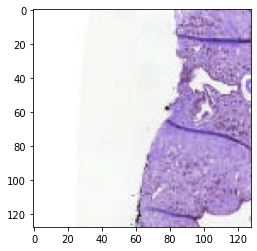

In [6]:
plt.imshow(img_array[1])
plt.show()

In [7]:
from sklearn.preprocessing import LabelBinarizer

In [8]:
data_df = pd.read_csv(df)

In [9]:
train_y = list(data_df['isup_grade'].values)
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)

In [10]:
train_x = np.reshape(img_array, (len(img_array), 128, 128, 3))
train_y_multi = np.empty(train_y.shape, dtype=train_y.dtype)
train_y_multi[:, 5] = train_y[:, 5]

In [11]:
for i in range(4, -1, -1):
    train_y_multi[:, i] = np.logical_or(train_y[:, i], train_y_multi[:,i+1])

In [12]:
train_y_multi.sum(axis=0)

array([1000,  678,  452,  317,  232,  148])

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y_multi, train_size=0.75, random_state=42)

In [15]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x)
x= Dense(512,activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(6,activation='softmax')(x) #FC-layer

2023-01-10 22:36:27.908613: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


29097984/29084464 [==============================] - 1s 0us/step


In [16]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [17]:
for layer in model.layers[:-8]:
    layer.trainable=False
for layer in model.layers[-8:]:
    layer.trainable=True

In [18]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
from keras.preprocessing.image import ImageDataGenerator

In [20]:
data = ImageDataGenerator(
    zoom_range = 0.15,
    fill_mode="nearest",
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True
)

In [21]:
data = data.flow(train_x, train_y, batch_size=32, seed=42)
validation = val_x, val_y

In [22]:
steps = train_x.shape[0] / 32

In [23]:
train_x.shape[0]

750

In [24]:
tf.config.run_functions_eagerly(True)

In [25]:
history = model.fit(
    data,
    steps_per_epoch = steps,
    epochs = 12,
    validation_data = validation
)

2023-01-10 22:36:32.841582: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12
23/23 [==============================] - 89s 4s/step - loss: 7.8593 - accuracy: 0.2040 - val_loss: 13.4671 - val_accuracy: 0.0000e+00
Epoch 2/12
23/23 [==============================] - 91s 4s/step - loss: 7.0365 - accuracy: 0.2760 - val_loss: 7.4816 - val_accuracy: 0.0000e+00
Epoch 3/12
23/23 [==============================] - 95s 4s/step - loss: 6.7162 - accuracy: 0.3707 - val_loss: 5.6289 - val_accuracy: 0.3040
Epoch 4/12
23/23 [==============================] - 100s 4s/step - loss: 6.2546 - accuracy: 0.4573 - val_loss: 5.5764 - val_accuracy: 0.5840
Epoch 5/12
23/23 [==============================] - 85s 4s/step - loss: 6.2356 - accuracy: 0.5787 - val_loss: 6.0376 - val_accuracy: 0.8880
Epoch 6/12
23/23 [==============================] - 86s 4s/step - loss: 6.4307 - accuracy: 0.6893 - val_loss: 6.6565 - val_accuracy: 0.9840
Epoch 7/12
23/23 [==============================] - 85s 4s/step - loss: 6.6597 - accuracy: 0.7280 - val_loss: 7.1939 - val_accuracy: 0.9840
Epoch 8/12

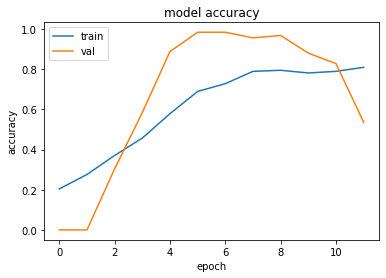

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

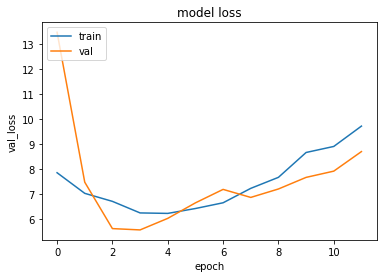

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
test = '/kaggle/input/test-image/test.png'

In [29]:
from PIL import Image
from numpy import asarray

img = Image.open(test)
numpydata = asarray(img)

In [30]:
numpydata.shape

(128, 128, 3)

In [31]:
#img = cv2.imread(test)
img = np.reshape(img, (1, 128, 128, 3))

In [32]:
pred = model.predict(img)

In [33]:
im_class = tf.argmax(pred[0], axis=-1)

In [34]:
print(im_class)

tf.Tensor(0, shape=(), dtype=int64)


In [35]:
model.save('model.h5')